In [2]:
!pip install -qU transformers

In [3]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config

from IPython import display

In [13]:
ferdousi = 'ferdousi.txt'
beyts = []

with open(ferdousi, 'r') as file:
    # Read the file line by line
    mesras = file.readlines()

    # Iterate through pairs of lines and join them with a tab
    for i in range(0, len(mesras), 2):
        # Ensure there's a pair of lines to join
        if i + 1 < len(mesras):
            # Join the lines with a tab and store in the new list
            joined_line = mesras[i].strip() + "<sep>" + mesras[i+1].strip()
            beyts.append(joined_line)
beyts.pop(0)

'ferdousi.txt<sep>number of beyts:\t49609'

In [14]:
print(beyts[0])

به نام خداوند جان و خرد<sep>کزین برتر اندیشه برنگذرد


In [6]:
model_name_or_path = "HooshvareLab/gpt2-fa"

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>',
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    model_name_or_path,
    bos_token_id=tokenizer("<s>")["input_ids"][0],
    eos_token_id=tokenizer("</s>")["input_ids"][0],
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

tokenizer.save_pretrained("/content/gpt2/")
config.save_pretrained("/content/gpt2/")

!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /content/gpt2/
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /content/gpt2/

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--2024-01-22 01:07:28--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 18.164.174.118, 18.164.174.23, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/HooshvareLab/gpt2-fa/46b0b806c740a0f0a9f056f5574c5fa896166fe844945fd3c849bf34365e5060?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1706144848&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNjE0NDg0OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9Ib29zaHZhcmVMYWIvZ3B0Mi1mYS80NmIwYjgwNmM3NDBhMGYwYTlmMDU2ZjU1NzRjNWZhODk2MTY2ZmU4NDQ5NDVmZDNjODQ5YmYzNDM2NWU1MDYwP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    "/content/gpt2",
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>'
)

print(tokenizer.encode("سلام بر شما"))
print(tokenizer.encode("<s>"))
print(tokenizer.encode("</s>"))
print(tokenizer.encode("<pad>"))
print(tokenizer.encode("<|startoftext|>"))
print(tokenizer.encode("<sep>"))

[8906, 327, 512]
[0]
[2]
[1]
[6]
[9]


In [15]:
max_seq = max([len(tokenizer.encode(text)) for text in beyts])

print(f'The longest text is {max_seq} tokens long.')

The longest text is 23 tokens long.


In [20]:
from torch.utils.data import Dataset  # this is the pytorch class import
import torch

class MTGDataset(Dataset):

    def __init__(self, txt, tokenizer, max_length=1024):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for i in range(0, len(txt), 2):
            input_encodings_dict = tokenizer('<s>' + txt[i] + '<sep>' + txt[i+1] + '</s>',
                                       truncation=True,
                                       max_length=max_length,
                                       padding="max_length")

            self.input_ids.append(torch.tensor(input_encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(input_encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [34]:
from torch.utils.data import random_split

dataset = MTGDataset(beyts, tokenizer, max_length=2*max_seq+1)

# Split into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'There are 23563 samples for training, and 1241 samples for validation testing'

In [35]:
print(train_dataset[0][0])
print(tokenizer.decode(train_dataset[0][0]))

tensor([   0, 4994,  580, 1617,  323,  557, 5869,  976,    9,  479,  397, 3982,
        8057, 1303,  429, 8057, 3195,    9,  319, 3079,  283,  394,  337, 1548,
         868,  662, 5922,    9,  479,  463,  555, 4435,  629,  397,  995,  356,
           2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1])
<s>چنین داد پاسخ که بازآر هوش<sep>که من پور قیدافه ام قیدروش<sep>جزین دخت فریان مرا نیست جفت<sep>که دارد پس پردهٔ من نهفت</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

In [37]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('./gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("./gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
# device = torch.device("cpu")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [38]:
epochs = 3
warmup_steps = 1e2
sample_every = 300

In [39]:
from transformers import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=5e-4,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

In [31]:
sample_beyt = beyts[np.random.randint(0, len(beyts))]
sample_input = '<s>' + sample_beyt + '<sep>'
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    do_sample=True,
    top_k=50,
    max_length=50,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
    gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
    gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
    gen_sample_output = gen_sample_output.replace("<s>", "")
    gen_sample_output = gen_sample_output.replace("</s>", "")
    gen_sample_output = gen_sample_output.replace("<sep>", "\n")

    print(f'Example output: {gen_sample_output}')

<s>جوان گرچه دانا بود با گهر<sep>ابی آزمایش نگیرد هنر<sep>
Example output: جوان گرچه دانا بود با گهر
ابی آزمایش نگیرد هنر
ک هنرپرور این مملکت را در کنار سایر اصناف قرار داد و به همین جهت وی تحت تأثیر اصناف دیگر نیز شد به همین جهت او را به شاگردی گماشتند و سپس به شاگردی پذیرفت


In [41]:
import random
import time
import datetime
from tqdm import tqdm


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print()
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_beyt = beyts[np.random.randint(0, len(beyts))]
            sample_input = '<s>' + sample_beyt + '<sep>'
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<s>", "\n")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                # gen_sample_output = gen_sample_output.replace("<pad>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")

                print(f'Example output: {gen_sample_output}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print()
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

  0%|          | 0/3 [00:00<?, ?it/s]

Beginning epoch 1 of 3


 10%|█         | 300/2946 [00:40<06:02,  7.30it/s]


Batch 300 of 2946. Loss:3.4717423915863037. Time:0:00:40


 10%|█         | 302/2946 [00:40<08:04,  5.46it/s]

Example output: 
جوان گرچه دانا بود با گهر
ابی آزمایش نگیرد هنر
به نزدیک او کسی کو ببیند سخن
همه شهر ایران همی بردش
بکوشیم بجایی


 20%|██        | 600/2946 [01:20<05:07,  7.62it/s]


Batch 600 of 2946. Loss:3.227830410003662. Time:0:01:21
Example output: 
ببستند یارانش یکسر کمر
همیدون به دریا نهادند سر
وزان جایگه برنشست اسپ کشید
بمان برشاه گفت آفرین


 31%|███       | 900/2946 [02:00<04:33,  7.49it/s]


Batch 900 of 2946. Loss:2.935476779937744. Time:0:02:01


 31%|███       | 902/2946 [02:01<06:21,  5.35it/s]

Example output: 
نوندی ز گفتار کارآگهان
بیامد به نزدیک شاه جهان
بیامد بر تختش چو مهتری
بیاورد و دینار و زریر و تختش به کف


 41%|████      | 1200/2946 [02:41<03:55,  7.41it/s]


Batch 1200 of 2946. Loss:2.987724542617798. Time:0:02:41


 41%|████      | 1202/2946 [02:41<05:37,  5.17it/s]

Example output: 
سرانجام اگر راه جویی بداد
هیونی برافگن بکردار باد
بجای آوریدند بر خویشتن
نه از بهر گاه اندرین و ز بهر خویشتن


 51%|█████     | 1500/2946 [03:21<03:15,  7.41it/s]


Batch 1500 of 2946. Loss:2.4718098640441895. Time:0:03:21


 51%|█████     | 1502/2946 [03:21<04:46,  5.05it/s]

Example output: 
بسی آفرین کرد بر شهریار
بدان شادمان گردش روزگار
که در بارگاهش بود شهریار
بدو گفت رستم که ای شاه کرد
سپهبد ز اندازه وز راه کرد


 61%|██████    | 1800/2946 [04:01<02:31,  7.54it/s]


Batch 1800 of 2946. Loss:2.476565361022949. Time:0:04:02


 61%|██████    | 1802/2946 [04:02<03:19,  5.73it/s]

Example output: 
برانگیزم از گاه کاووس را
از ایران ببرم پی طوس را
که لشکر بیامد سوی مرز روم
بشد دست و پای اندر افگند بوم


 71%|███████▏  | 2100/2946 [04:41<01:51,  7.55it/s]


Batch 2100 of 2946. Loss:2.2309682369232178. Time:0:04:42


 71%|███████▏  | 2102/2946 [04:42<02:30,  5.62it/s]

Example output: 
سواران ز بس رنج و اسبان ز تگ
یکی را بتن بر نجنبید رگ
به زین بر سر نیزه و تیر و کمان
همه پیش برفتند با او به هم


 81%|████████▏ | 2400/2946 [05:21<01:11,  7.61it/s]


Batch 2400 of 2946. Loss:2.698749303817749. Time:0:05:22
Example output: 
بیامد بر تاجور سوفزای
به دستوری بازگشتن به جای
به نزدیک افراسیاب آمدند
وزان جایگه و پیش افراسیاب آمدند


 92%|█████████▏| 2700/2946 [06:01<00:32,  7.54it/s]


Batch 2700 of 2946. Loss:2.35710072517395. Time:0:06:02
Example output: 
ازان پس بران تیرگی بگذرم
بخاک اندر آید سر و افسرم
برو بر زمین آبنوس و سپاه
نه هنگام گردان ایران و سپاه


100%|██████████| 2946/2946 [06:34<00:00,  7.46it/s]



Average Training Loss: 2.857088963676292. Epoch time: 0:06:35



 33%|███▎      | 1/3 [06:39<13:19, 399.89s/it]


Validation loss: 2.4207422183110165. Validation Time: 0:00:05

Beginning epoch 2 of 3


 10%|█         | 300/2946 [00:39<05:51,  7.52it/s]


Batch 300 of 2946. Loss:2.2563905715942383. Time:0:00:40


 10%|█         | 302/2946 [00:40<07:57,  5.54it/s]

Example output: 
ز گیتی برو بر کنند آفرین
که بی تو مبادا زمان و زمین
برآمد خروشیدن تیغ و کوس
زبر زنگار و بوقار و آوای کوس


 20%|██        | 600/2946 [01:20<05:11,  7.52it/s]


Batch 600 of 2946. Loss:2.169152021408081. Time:0:01:20
Example output: 
گنهکار یزدانی وناسپاس
تن اندر نکوهش دل اندر هراس
بگویش که بی کار باشد هنر
نباشد برین روزگار هنر


 31%|███       | 900/2946 [02:00<04:34,  7.45it/s]


Batch 900 of 2946. Loss:2.4390268325805664. Time:0:02:01


 31%|███       | 902/2946 [02:01<06:26,  5.29it/s]

Example output: 
کنون چون زنان پیش من بسته دست
همی خواب گویی به کردار مست
مرا نیز چون خواب دشمن مدار
به سر تا نیایم من او را به خار


 41%|████      | 1200/2946 [02:40<03:56,  7.39it/s]


Batch 1200 of 2946. Loss:2.2968883514404297. Time:0:02:41


 41%|████      | 1201/2946 [02:41<06:29,  4.48it/s]

Example output: 
چهارم چنین گفت شاه جهان
ابا پیشکارش سخن درنهان
که هرکس که این راز گویم
به خواب اندرون شوربخت نویم


 51%|█████     | 1500/2946 [03:21<03:13,  7.49it/s]


Batch 1500 of 2946. Loss:2.2525954246520996. Time:0:03:21


 51%|█████     | 1502/2946 [03:21<04:13,  5.70it/s]

Example output: 
یکی داستان زد جهاندیده کی
که مرد جوان چون بود نیک پی
تو دانی که او پهلوانست و بس
نباشم یکی پور دستان رس


 61%|██████    | 1800/2946 [04:01<02:32,  7.53it/s]


Batch 1800 of 2946. Loss:2.1622862815856934. Time:0:04:01
Example output: 
نگوید سخن جز همه راستی
نخواهد به داد اندرون کاستی
اگر دین نباشد به ما دسترس
ز کردار بد روی گردد دژم


 71%|███████▏  | 2100/2946 [04:41<01:52,  7.53it/s]


Batch 2100 of 2946. Loss:2.302199602127075. Time:0:04:42


 71%|███████▏  | 2102/2946 [04:41<02:29,  5.65it/s]

Example output: 
پرستنده گفتا چو فرمان دهی
گذاریم تا کاخ سرو سهی
در گنجهای کهن برگشاد
نکردند خشک و در و درم یاد کرد


 81%|████████▏ | 2400/2946 [05:21<01:12,  7.50it/s]


Batch 2400 of 2946. Loss:2.083523750305176. Time:0:05:22


 82%|████████▏ | 2402/2946 [05:22<01:35,  5.71it/s]

Example output: 
ترا آشتی بهتر آید ز جنگ
فراخی مکن بر دل خویش تنگ
بدو گفت خاقان که بر انجمن
نباشی همی کین و دل را شکن


 92%|█████████▏| 2700/2946 [06:01<00:32,  7.47it/s]


Batch 2700 of 2946. Loss:2.210679531097412. Time:0:06:02


 92%|█████████▏| 2702/2946 [06:02<00:43,  5.66it/s]

Example output: 
مبادا ز تو تخت پردخت و گاه
مه این نامور خسروانی کلاه
دگر گفت کز تخم کاوس کی
نشاید به بد کردن آهنگ پی


100%|██████████| 2946/2946 [06:34<00:00,  7.46it/s]



Average Training Loss: 2.156007592765474. Epoch time: 0:06:35



 67%|██████▋   | 2/3 [13:19<06:39, 400.00s/it]


Validation loss: 2.2436702809272666. Validation Time: 0:00:05

Beginning epoch 3 of 3


 10%|█         | 300/2946 [00:40<05:52,  7.50it/s]


Batch 300 of 2946. Loss:1.5506917238235474. Time:0:00:40


 10%|█         | 302/2946 [00:40<07:43,  5.70it/s]

Example output: 
به تاراج داد آن همه خواسته
زن و کودک و گنج آراسته
به هر جای دشمن پراگنده شد
به بدخواه بی راه آگنده شد


 20%|██        | 600/2946 [01:20<05:17,  7.38it/s]


Batch 600 of 2946. Loss:1.8692682981491089. Time:0:01:20


 20%|██        | 602/2946 [01:20<07:15,  5.38it/s]

Example output: 
سپاهش بکوه کنابد شود
بجنگ اندرون دست ما بد شود
بجنگ اندر آید بداد اندرون
تو باید که باشی بجنگ اندرون


 31%|███       | 900/2946 [02:00<04:35,  7.43it/s]


Batch 900 of 2946. Loss:1.6974761486053467. Time:0:02:01


 31%|███       | 902/2946 [02:01<06:28,  5.27it/s]

Example output: 
ازان درد بگریست افراسیاب
همی کند موی و همی ریخت آب
چنان دید روشن که یزدان پاک
نیایش همی کرد روشن به خاک


 41%|████      | 1200/2946 [02:40<03:52,  7.52it/s]


Batch 1200 of 2946. Loss:1.6534119844436646. Time:0:02:41


 41%|████      | 1202/2946 [02:41<05:10,  5.62it/s]

Example output: 
بفرمود تا زو بپرسند شاه
که جام نبید از چه داری نگاه
به رامش همی بود تا گاه شام
به جام اندرون بانگ زد با سپاه


 51%|█████     | 1500/2946 [03:21<03:14,  7.45it/s]


Batch 1500 of 2946. Loss:1.805173635482788. Time:0:03:21
Example output: 
ترا بهتر آید که فرمان کنی
رخ نامور سوی توران کنی
یکی گنج ویژه به من بر ببخش
پرستنده بر دل نیاید به یاد


 61%|██████    | 1800/2946 [04:01<02:32,  7.50it/s]


Batch 1800 of 2946. Loss:1.702398419380188. Time:0:04:01
Example output: 
ز تو دور شد فره و بخردی
بیابی تو بادافره ایزدی
ز شاهان ترا بی نیازی دهد
بدانجا که بی نیازی دهد


 71%|███████▏  | 2100/2946 [04:41<01:52,  7.52it/s]


Batch 2100 of 2946. Loss:1.687252402305603. Time:0:04:42
Example output: 
به گیتی نگر کین هنرها کراست
چو دیدی ستایش مر او را سزاست
خرد باید و راستی و فر
خرد بادت آموزگار


 81%|████████▏ | 2400/2946 [05:21<01:12,  7.57it/s]


Batch 2400 of 2946. Loss:1.6775894165039062. Time:0:05:22


 82%|████████▏ | 2402/2946 [05:21<01:35,  5.72it/s]

Example output: 
به طرخان چنین گفت کای سرفراز
برو تیز با لشکری رزمساز
چه دیدی چو گودرز پیش سپاه
چرا رنجه کردی مرا راه و راه


 92%|█████████▏| 2700/2946 [06:01<00:32,  7.51it/s]


Batch 2700 of 2946. Loss:1.7671623229980469. Time:0:06:02


 92%|█████████▏| 2702/2946 [06:02<00:42,  5.72it/s]

Example output: 
همی زور و بخت از جهاندار دید
وز آن گردش بخت بیدار دید
خروش آمد و نالهٔ کرنای
تو گفتی به آتش برافروخت جای


100%|██████████| 2946/2946 [06:34<00:00,  7.47it/s]



Average Training Loss: 1.673177032185831. Epoch time: 0:06:35



100%|██████████| 3/3 [19:59<00:00, 399.94s/it]


Validation loss: 2.251039817547187. Validation Time: 0:00:05

Total training took 0:20:00


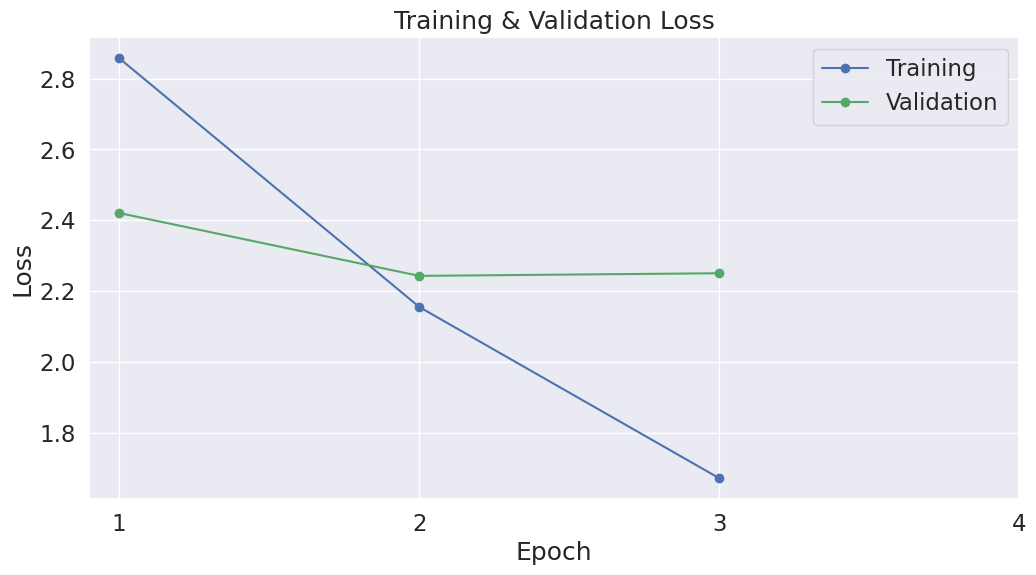

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [44]:
import os

output_dir = '/content/gpt2-fa-ferdousi'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
configuration.save_pretrained(output_dir)
!cp /content/gpt2/tokenizer.json /content/gpt2-fa-ferdousi/

In [45]:
!zip -r gpt2-fa-ferdousi.zip gpt2-fa-ferdousi

  adding: gpt2-fa-ferdousi/ (stored 0%)
  adding: gpt2-fa-ferdousi/added_tokens.json (stored 0%)
  adding: gpt2-fa-ferdousi/model.safetensors (deflated 7%)
  adding: gpt2-fa-ferdousi/tokenizer.json (deflated 79%)
  adding: gpt2-fa-ferdousi/special_tokens_map.json (deflated 79%)
  adding: gpt2-fa-ferdousi/merges.txt (deflated 74%)
  adding: gpt2-fa-ferdousi/vocab.json (deflated 73%)
  adding: gpt2-fa-ferdousi/config.json (deflated 51%)
  adding: gpt2-fa-ferdousi/tokenizer_config.json (deflated 85%)
  adding: gpt2-fa-ferdousi/generation_config.json (deflated 28%)


In [46]:
from google.colab import drive
drive.mount('/content/drive')
!cp gpt2-fa-ferdousi.zip /content/drive/MyDrive

Mounted at /content/drive


In [47]:
model.eval()

for i in range(20):
    sample_beyt = beyts[np.random.randint(0, len(beyts))]
    sample_input = '<s>' + sample_beyt + '<sep>'
    sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
    sample_input_ids = sample_input_ids.to(device)

    sample_outputs = model.generate(
        input_ids=sample_input_ids,
        do_sample=True,
        top_k=50,
        max_length=50,
        top_p=0.95,
        num_return_sequences=1
    )
    for i, sample_output in enumerate(sample_outputs):
        gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
        gen_sample_output = gen_sample_output.replace("<s>", "\n")
        gen_sample_output = gen_sample_output.replace("</s>", "")
        # gen_sample_output = gen_sample_output.replace("<pad>", "")
        gen_sample_output = gen_sample_output.replace("<sep>", "\n")

        print(f'Example output: {gen_sample_output}')


Example output: 
نباشم همیدون من او را نیا
نجویم همی زین سخن کیمیا
و دیگر که با اختر خوب چهر
همی نو کنم بخشش و داد و مهر
Example output: 
به شادی و انده نگردد دگر
برین نیست پیکار با دادگر
چو افراسیاب آن ببیند بخواب
ببر بر نباشد مرا جای خواب
Example output: 
نشسته برو شهریاری چو ماه
یکی تاج بر سر به جای کلاه
سپهدار نوذر گو را بدید
سپهبد پذیره شد و تاج دید
Example output: 
بباید بریدن سر خویش پست
بخون غرقه کردن بر و یال و دست
بگردن نهادن بجنگ منست
ببالای او در جهان کام منست
Example output: 
به نزد بزرگان ایرانیان
نوشتن همین نامه بر پرنیان
نوشته به چینی پرند آن زمان
فرستاد خاقان سوی آسمان
Example output: 
کنون روز دادست بیداد شد
سران را سر از کشتن آزاد شد
چو بیدادگر شد ز گردان سپهر
برفتند گردان پرخاشخر
Example output: 
ز بیگانه پردخته کردند جای
سگالش گرفتند هر گونه رای
که تا شاه بهرام پیروزگر
چنین تیزچنگ آیدش روز و شب
Example output: 
سپهبد فرستاد نزدیک اوی
سپاهی بلند اختر و رزمجوی
سپاهی بیاورد پرمایه از
ز زرینه و جامه های درم
Example output: 
ز یک سو بیابان بی آب و نم
کلات از دگر سوی و ر

In [50]:
import math

model.eval()

total_eval_loss = 0
total_tokens = 0

for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

        loss = outputs.loss

        num_tokens = torch.sum(b_masks).item()

        total_tokens += num_tokens
        total_eval_loss += loss.item() * num_tokens

avg_eval_loss = total_eval_loss / total_tokens

perplexity = math.exp(avg_eval_loss)
print()
print(f'Perplexity on validation data: {perplexity}')

100%|██████████| 156/156 [00:07<00:00, 21.45it/s]


Perplexity on validation data: 9.483074472145526
